## Imports

In [93]:
#imports
import nltk
from nltk.corpus import wordnet_ic
from nltk.corpus import wordnet as wn
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
#corpus and IC
nltk.download('wordnet')
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


True

## Functions

In [31]:
# Mapping of Stanford POS-tag to WordNet type
#thanks to pywsd ! 
#https://github.com/alvations

def penn2morphy(penntag, returnNone=False):
    morphy_tag = {'NN':wn.NOUN, 'JJ':wn.ADJ,
                  'VB':wn.VERB, 'RB':wn.ADV}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return None if returnNone else ''

In [32]:
def get_synsets(list_of_tup):
  syns =[]
  d = dict()
  for x in list_of_tup: 
    try:
      y = wn.synsets(x[0],pos=penn2morphy(x[1])) #POS TAG IS ANNOYING
      if len(y)> 0: 
        syns.append(y[0])
        d[x[0]] = y
      else:
        pass
    except: 
      pass
  

  return syns,d

In [1]:
# function that converts tuple to string
def join_tuple_string(strings_tuple) -> str:
   return '-'.join(strings_tuple)

In [34]:
def key_value_tuple_list_comb(d):
  # all combinations of keys
  key_list_tuples = list(itertools.combinations(d.keys(), 2))

  # all combinations of values
  # adjust for dicts of lists 
  dd = sum([x for x in d.values()],[]) #condensing
  dd = [x.name() for x in dd]
  values_list_tuples = list(itertools.combinations(dd,2))

  # joining all the tuples
  result = list(map(join_tuple_string, key_list_tuples))
  result2 = list(map(join_tuple_string, values_list_tuples))

  return result, result2, key_list_tuples,values_list_tuples

In [35]:
def get_similarities(word1, word2,brown_ic):

  '''
  input --> Word1, Word2
  Output --> dict of similarities 

  '''
  simil_dict = dict()

  def path_sim(word1,word2): 
    return word1.path_similarity(word2)
  def lch_sim(word1,word2): 
    return word1.lch_similarity(word2)
  def wup_sim(word1,word2): 
    return word1.wup_similarity(word2)
  def lin_sim(word1,word2,brown_ic): 
    '''
    needs information content (IC) of LCS (least common subsumer)
    '''
    return word1.lin_similarity(word2,brown_ic)

  simil_dict['PATH_SIMIL'] = path_sim(word1,word2)
  simil_dict['LCH_SIMIL'] = lch_sim(word1,word2)
  simil_dict['WUP_SIMIL'] = wup_sim(word1,word2)
  simil_dict['LIN_SIMIL'] = lin_sim(word1,word2,brown_ic)

  return simil_dict

In [36]:
def conv_synset(x):
  return wn.synset(x)

In [37]:
def get_LCS(list_of_tuple_values):

  LCS = []

  for x in list_of_tuple_values:
    word1 = conv_synset(x[0])
    word2 = conv_synset(x[1])
    lcs = word1.lowest_common_hypernyms(word2)
    if len(lcs) !=0:
      LCS.append(lcs)
    else: 
      LCS.append(0)
    
  return LCS

In [38]:
def  final_df(results_2, list_of_tuples):

  df1 = pd.DataFrame({"Combination":result2})
  df1['LCS'] = get_LCS(values_list_tuples)
  #filtering
  df2 = df1.copy()
  mask = df2['LCS'] == 0
  df2_mask = df2[~mask]
  diff = df2.shape[0] - df2_mask.shape[0]

  # splitting
  df2_mask['SynsetA'] = df2_mask.Combination.apply(lambda x: x.split('-')[0])
  df2_mask['SynsetB'] = df2_mask.Combination.apply(lambda x: x.split('-')[1])
  df2_mask['WordA'] = df2_mask.Combination.apply(lambda x: x.split('-')[0])
  df2_mask['WordA'] = df2_mask.Combination.apply(lambda x: x.split('.')[0])
  df2_mask['WordB'] = df2_mask.Combination.apply(lambda x: x.split('-')[1])
  df2_mask['WordB'] = df2_mask.Combination.apply(lambda x: x.split('.')[0])
  #applying type
  df2_mask['SynsetA'] = df2_mask['SynsetA'].apply(lambda x: wn.synset(x))
  df2_mask['SynsetB'] = df2_mask['SynsetB'].apply(lambda x: wn.synset(x))

  ## DataFrame to merge
  li = []
  synsa = list(df2_mask['SynsetA'].values)
  synsb = list(df2_mask['SynsetB'].values)
  synsz = list(zip(synsa,synsb))

  for x in synsz:
    vals = get_similarities(x[0],x[1],brown_ic)
    li.append(vals)
  


  df3 = pd.DataFrame(li)
  dfinal = pd.concat([df2_mask,df3],axis=1)
  #cleaning
  dfinal = dfinal.drop(['SynsetA','SynsetB'],axis=1)
  mask_2 = dfinal['LCS'] == 0
  df_final = dfinal[~mask]
  df_final['LCS'] = df_final['LCS'].apply(lambda x: x[0].name())
  #df_final = df_final.dropna(axis=0)


  return df_final

## Work

In [39]:
#Setting the information content for LCS
brown_ic = wordnet_ic.ic('ic-brown.dat')

In [40]:
#selected word pairs with POS (word,POS)
word_pairs = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

In [41]:
# all synsets
a,d = get_synsets(word_pairs)

In [42]:
result1, result2, key_list_tuples,values_list_tuples = key_value_tuple_list_comb(d)

In [44]:
final_df = final_df(result2,values_list_tuples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [45]:
final_df = final_df.fillna(0)
final_df=final_df[final_df['PATH_SIMIL']>0]

In [46]:
final_df.groupby(['WordA','LCS']).mean()

PATH_SIMIL  LCH_SIMIL  WUP_SIMIL  LIN_SIMIL
WordA      LCS                                                       
homo       entity.n.01      0.125000   1.558145   0.571429   0.304235
           homo.n.02        0.250000   2.251292   0.631579   0.726047
           object.n.01      0.333333   2.538974   0.666667   0.697863
           organism.n.01    0.136781   1.616087   0.569290   0.298239
           whole.n.02       0.250000   2.251292   0.631579   0.694358
man        adult.n.01       0.269231   2.172390   0.683333   0.685042
           entity.n.01      0.153098   1.555345   0.422274   0.394593
           male.n.02        0.182330   1.776265   0.500683   0.361565
           man.n.01         0.155556   1.734255   0.606061   0.342819
           object.n.01      0.138202   1.551091   0.457789   0.292214
           organism.n.01    0.125161   1.442332   0.494530   0.399096
           person.n.01      0.164511   1.672321   0.530986   0.365148
           whole.n.02       0.146900   1.548889   0.514248   0.459608
           worker.n.01      0.138889   1.643094   0.530075   0.235190
serviceman entity.n.01      0.125000   1.558145   0.571429   0.304943
           object.n.01      0.083333   1.152680   0.153846   0.000000
           organism.n.01    0.154762   1.768751   0.615789   0.340567
           person.n.01      0.197109   1.987703   0.651593   0.342841
           whole.n.02       0.090909   1.239691   0.545455   0.346887
           worker.n.01      0.186508   1.929598   0.645820   0.319284
valet      entity.n.01      0.166667   1.845827   0.631579   0.285906
           object.n.01      0.200000   1.648659   0.250000   0.374594
           organism.n.01    0.333333   2.159484   0.333333   0.374594
           person.n.01      0.220238   1.991907   0.551746   0.519160
           whole.n.02       0.250000   1.871802   0.285714   0.374594
           worker.n.01      0.166667   1.845827   0.631579   0.274628

In [47]:
final_df.groupby('WordA').mean()

,PATH_SIMIL,LCH_SIMIL,WUP_SIMIL,LIN_SIMIL
WordA,,,,
homo,0.157342,1.722855,0.580494,0.359716
man,0.161382,1.656113,0.512967,0.368981
serviceman,0.178537,1.868394,0.616458,0.322300
valet,0.221148,1.957323,0.514891,0.465543


In [49]:
#normalizing to [0,1]
final_df['LCH_SIMIL'] = (final_df['LCH_SIMIL'] - final_df['LCH_SIMIL'].min()) / (final_df['LCH_SIMIL'].max() - final_df['LCH_SIMIL'].min())

final_df = final_df.drop(['WordB'],axis=1)

In [50]:
final_df.head()

,Combination,LCS,WordA,PATH_SIMIL,LCH_SIMIL,WUP_SIMIL,LIN_SIMIL
0,man.n.01-serviceman.n.01,person.n.01,man,0.166667,0.454757,0.631579,0.387054
1,man.n.01-man.n.03,person.n.01,man,0.250000,0.655990,0.705882,0.356225
2,man.n.01-homo.n.02,organism.n.01,man,0.083333,0.110747,0.521739,0.365775
3,man.n.01-man.n.05,person.n.01,man,0.142857,0.378251,0.600000,0.356225
4,man.n.01-man.n.06,male.n.02,man,0.333333,0.798767,0.666667,0.813972


## Synsets for all words

In [52]:
# printing the synsets
for key, value in d.items():
  print(f"------->{key}<-------")
  print(f"Synsets:")
  for x in value:
    print(f"{x.name()}")
  print("\n")

------->man<-------
Synsets:
man.n.01
serviceman.n.01
man.n.03
homo.n.02
man.n.05
man.n.06
valet.n.01
man.n.08
man.n.09
man.n.10
world.n.08


------->swim<-------
Synsets:
swim.v.01
float.v.02
swim.v.03
swim.v.04
swim.v.05


------->girl<-------
Synsets:
girl.n.01
female_child.n.01
daughter.n.01
girlfriend.n.02
girl.n.05


------->boy<-------
Synsets:
male_child.n.01
boy.n.02
son.n.01
boy.n.04


------->woman<-------
Synsets:
woman.n.01
woman.n.02
charwoman.n.01
womanhood.n.02


------->walk<-------
Synsets:
walk.v.01
walk.v.02
walk.v.03
walk.v.04
walk.v.05
walk.v.06
walk.v.07
walk.v.08
walk.v.09
walk.v.10




In [112]:
# Combinations and their LCS
print(final_df[['Combination','LCS']])

                  Combination            LCS
0    man.n.01-serviceman.n.01    person.n.01
1           man.n.01-man.n.03    person.n.01
2          man.n.01-homo.n.02  organism.n.01
3           man.n.01-man.n.05    person.n.01
4           man.n.01-man.n.06      male.n.02
..                        ...            ...
291         man.n.09-boy.n.04    object.n.01
292       man.n.09-woman.n.01    object.n.01
293       man.n.09-woman.n.02    object.n.01
294   man.n.09-charwoman.n.01    object.n.01
295   man.n.09-womanhood.n.02    entity.n.01

[171 rows x 2 columns]


## Graphs

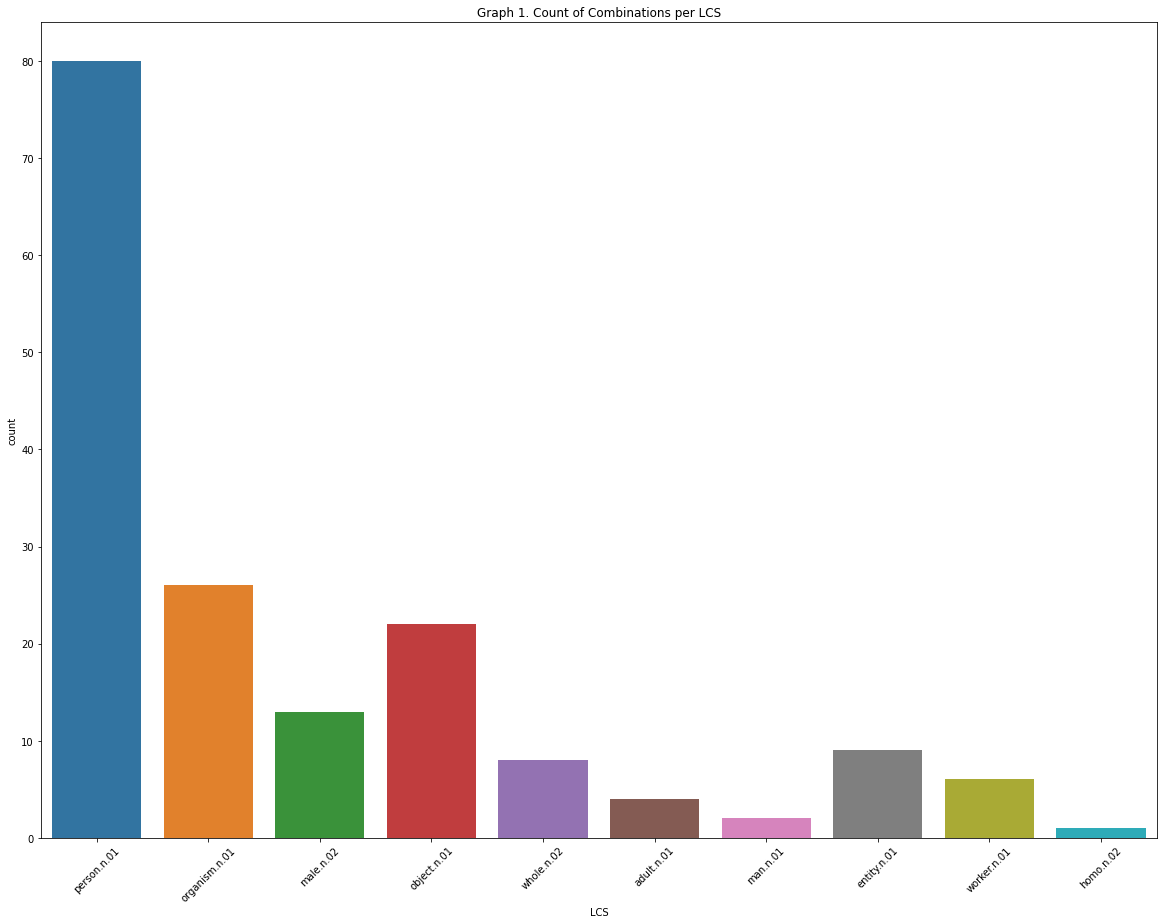

In [92]:

plt.figure(figsize=(20,15))
chart = sns.countplot(
    data=final_df,
    x='LCS',
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Graph 1. Count of Combinations per LCS')
plt.show()

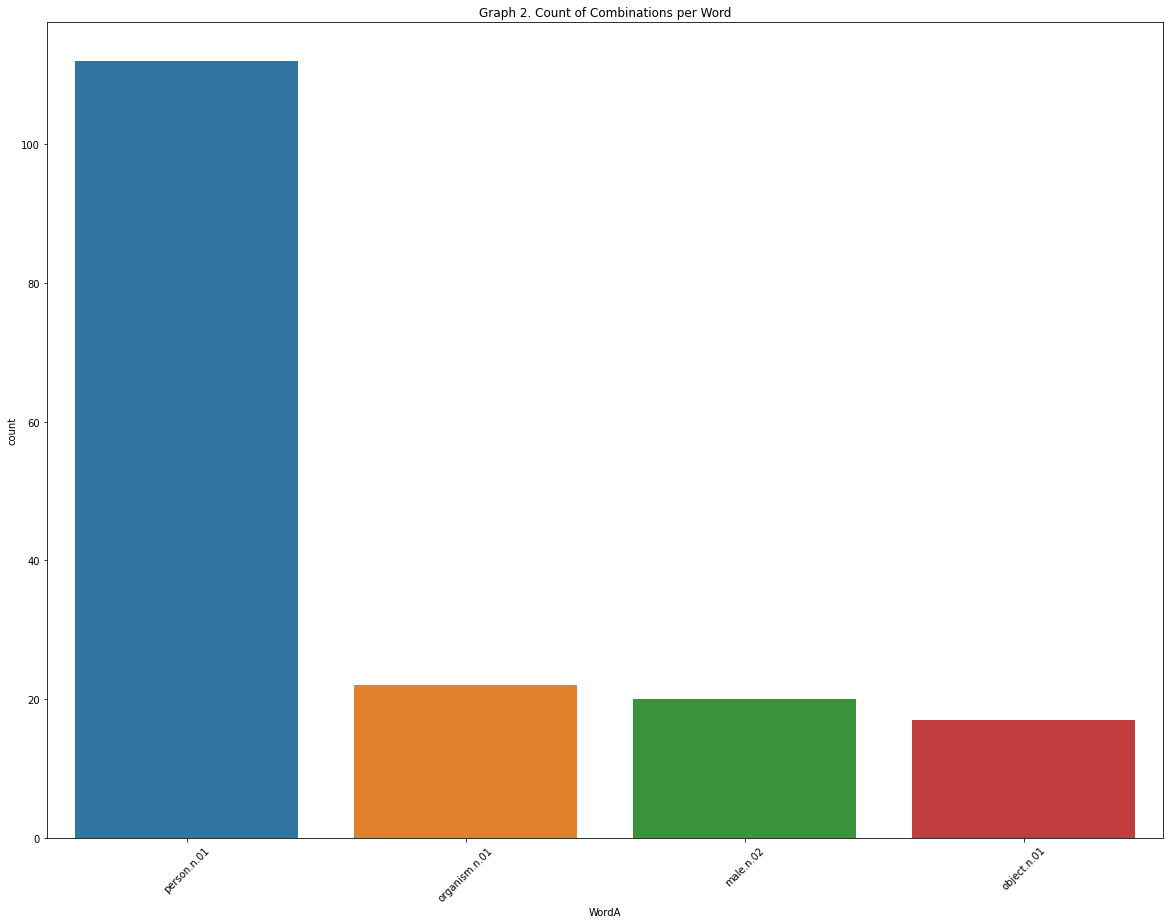

In [94]:

plt.figure(figsize=(20,15))
chart2 = sns.countplot(
    data=final_df,
    x='WordA',
)
chart2.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart2.set_title('Graph 2. Count of Combinations per Word')
plt.show()

In [96]:
sims = ['PATH_SIMIL','LCH_SIMIL','WUP_SIMIL','LIN_SIMIL']

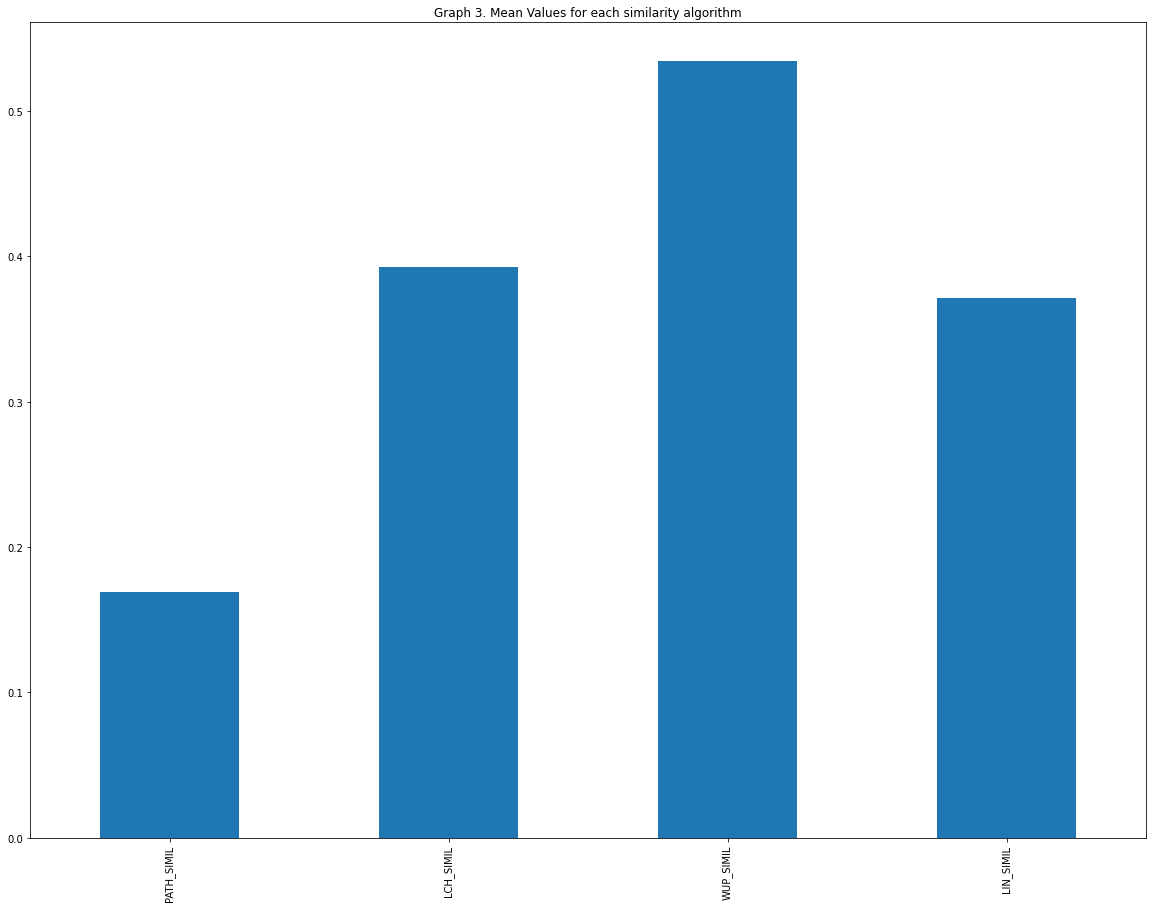

In [103]:
final_df[sims].mean().plot(kind='bar',title='Graph 3. Mean Values for each similarity algorithm',figsize=(20,15));

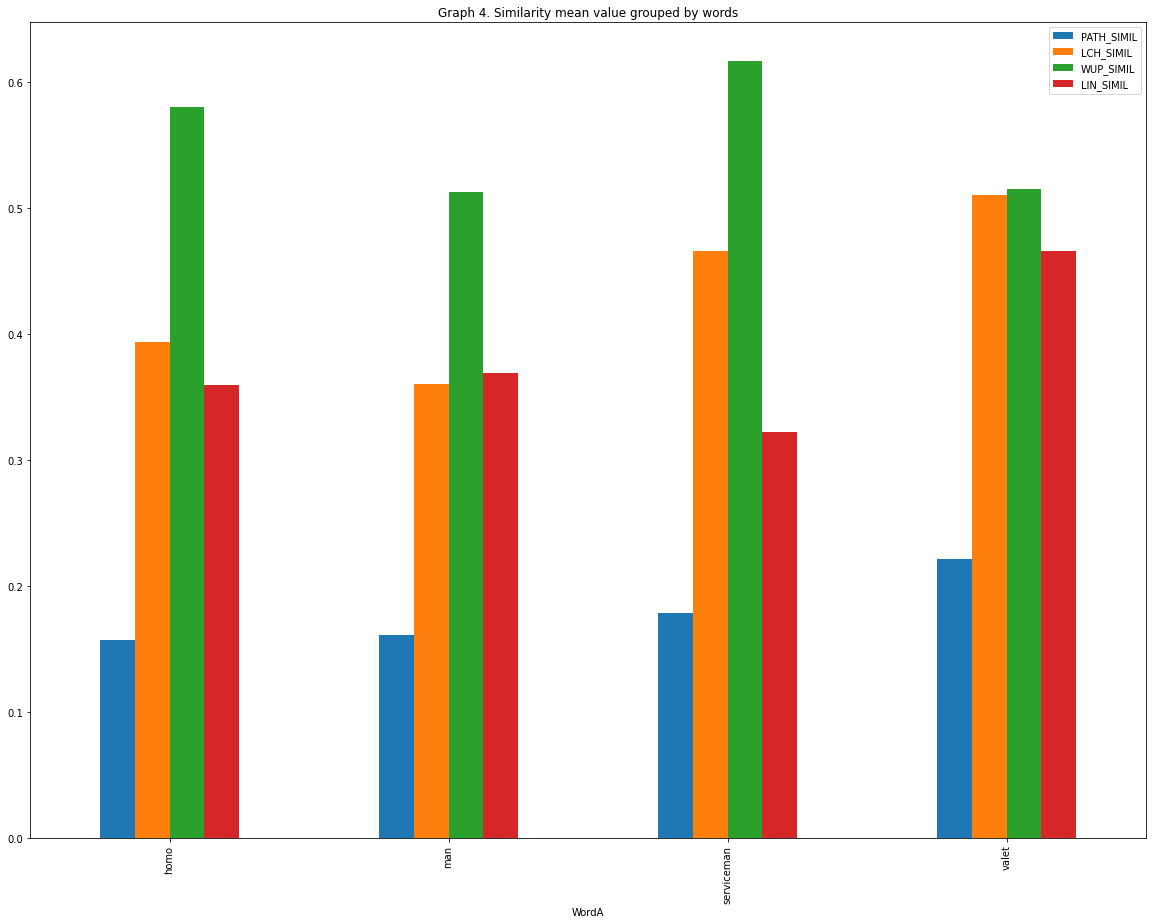

In [108]:
final_df.groupby('WordA').mean().plot(kind='bar',figsize=(20,15),title='Graph 4. Similarity mean value grouped by words');



## Description
During this lab we used the NLTK.Wordnet as well as NLTK.Wordnet_IC. NLTK.Wordnet is a database which groups a specified language (this case English), words into sinonyms called synsets. From these synsets we want to evaluate the semantic similarities compared to the synsets of the other words. 

In order to do this, we need to do the following: 
- Find all the synsets for all provided pairs (if possible). 
- Find all possible combinations of the synsets. 
- Get the LCS for all the possible combinations (if it exists). 
- Calculate the similarity scores using four different scores: 
1. Path Similarity 
2. Lin Similarity 
3. Wu-Palmer Similarity 
4. Leacock-Chodorow Similarity

## Evaluation

The data is presented in the following way: 

We created a dataframe which contains all the combinations, LCS, the original word, and their corresponding similarities. From here we did some further evaluation, such as looking at the number of combinations per LCS, as well as number of combinations per word. Lastly, we decided to look at the mean value for each of the algorithms. 

## Summary
Since the different similarity scores have a different definition, we need to take a look at all of them. 
Since there was no Path Similarity above 30% we can say that the relationships of the words wihin their shortest path is low. 
LCH increases, since it is based upong the relationship of the shortest path length and the taxonomy depth. In this case reaching a value of over 50% in some cases. 
The Wu Palmer, shows the similarity but incluiding the word sense based on their LCS as well! This is interesting because it gives an added level of comparisson between the two words. However, LCS selects the value if the shortest path to the root node is the longest, meaning it could have issues with multiple LCS canditates. 
Lastly the Lin similarity, returns a score based on the IC (Information Content) of the LCS! This is even more interesting because it gets the LCS such that it is the most specific ancestor node. 

In this case, for us, the Lin Similarity is what we defined as "better" because it uses the LCS as well as the Brown IC. Taking into account the IC and the LCS, gives a stronger sense of relationship between the words. 